In [ ]:
import torch
import json
import numpy as np
import torchvision
import os
from torchvision import transforms
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 32

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

llrs = np.logspace(-4, -3, 5).tolist()[:-1] + np.logspace(-3, -2, 15).tolist()[:-1] + np.logspace(-2, -1, 4).tolist()
actual_lrs = [float(f"{lr:.6e}") for lr in llrs]
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

plot_folder = './'
os.makedirs(plot_folder, exist_ok=True)

def download_folder(folder_name):
    triples = []
    data = []
    for p in Path(folder_name).iterdir():
        name = p.name
        if name.startswith("lr"):
            lr = float(name[2:])
            if not os.path.exists(f'{folder_name}/{name}/trace.pt'):
                continue
            if lr not in actual_lrs:
                continue
            f = torch.load(f'{folder_name}/{name}/trace.pt', map_location=torch.device('cpu'))
            tr = f['trace']
            with open(f'{folder_name}/{name}/config.json', 'r') as f:
                cfg = (json.load(f))
            triples.append((lr, tr, cfg))
    triples.sort(key=lambda x: x[0])
    lrs = [x[0] for x in triples]
    trace = [x[1] for x in triples]
    config = [x[2] for x in triples]
    num_params = len(trace[0]['weight'][0])
    return lrs, trace, config, num_params

f1 = f"../../exp-convnet8-seed1-cifar10-50000obj-ce"
f2 = f"../../exp-convnet64-seed1-cifar10-50000obj-ce"
lrs_up, trace_up, config_up, num_params_up = download_folder(f1)
lrs_op, trace_op, config_op, num_params_op = download_folder(f2)
lrs_up = np.array(lrs_up)
lrs_op = np.array(lrs_op)
assert (lrs_up == lrs_op).all()

#### UP train iter

In [2]:
k_id = 5
window = 50
lrs_id = [0, 1, 2, 3, 4, 6, 8, 11, 14, 17, 19, 21]
len(lrs_id)

12

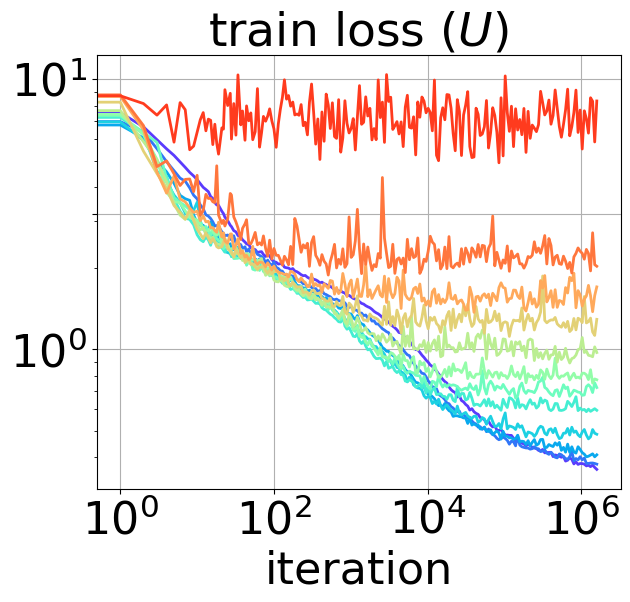

<Figure size 600x100 with 0 Axes>

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
fig.tight_layout()

cmap = sns.color_palette('rainbow', len(lrs_id))

for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['train_loss'])]
    ax.plot(iters, trace_up[lr_id]['train_loss'], color=cmap[i],
            label=f'{lrs_up[lr_id]:.1e}', linewidth=2)

ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_yticks(10. ** np.array([0, .5, 1.]))
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
ax.set_title('train loss ($U$)', fontsize=34)
ax.set_xlabel('iteration')
handles, labels = ax.get_legend_handles_labels()
fig.savefig(f'{plot_folder}up_loss_iter_conv.png', dpi=200, bbox_inches='tight')

fig_legend = plt.figure(figsize=(6, 1))
leg = fig_legend.legend(handles, labels, title="LR", borderaxespad=0, ncol=2, 
                    loc='center', frameon=True, fancybox=True, title_fontsize='medium')
frame = leg.get_frame()       
frame.set_linewidth(2)      
frame.set_edgecolor("grey") 
fig_legend.tight_layout()
fig_legend.savefig(f'{plot_folder}up_loss_iter_conv_legend.png', dpi=200, bbox_inches='tight',
                       pad_inches=0, transparent=False)
fig_legend.show()

#### UP entropy iter

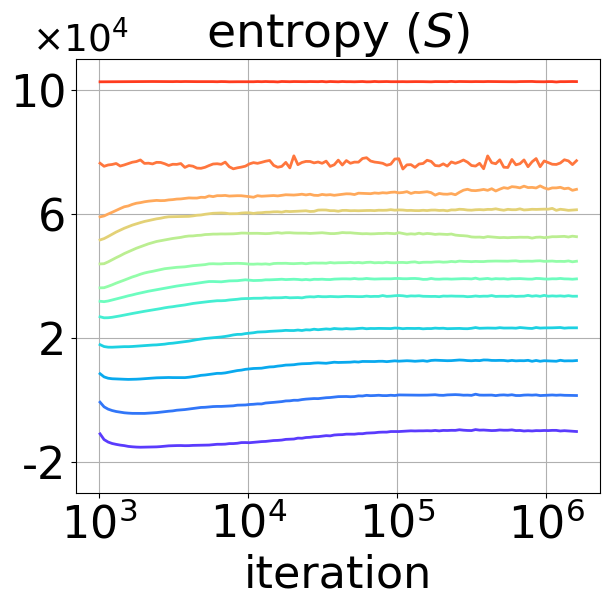

In [4]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
fig.tight_layout()

cmap = sns.color_palette('rainbow', len(lrs_id))

for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['train_loss'])]
    ents = [x.squeeze()[k_id] for x in trace_up[lr_id]['traj_ents']]
    ax.plot(iters, ents, color=cmap[i], label=f'{lrs_up[lr_id]:.1e}', linewidth=2)

ax.grid(True)
ax.set_xscale('log')
ax.set_yticks([-2e4, 2e4, 6e4, 10e4])
ax.set_xticks(10 ** np.array([3, 4, 5, 6]))
ax.set_ylim(-3e4, 11e4)

scale      = 1e4             
ndecimals  = 0            

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{y/scale:.{ndecimals}f}')
)
ax.annotate(r'$\times 10^4$',
                 xy=(0.1, 1.), xycoords='axes fraction',
                 ha='right', va='bottom', fontsize=27)

ax.set_title('entropy ($S$)', fontsize=34)
ax.set_xlabel('iteration')
fig.savefig(f'{plot_folder}up_entropy_iter_conv.png', dpi=200, bbox_inches='tight')

#### OP loss iter

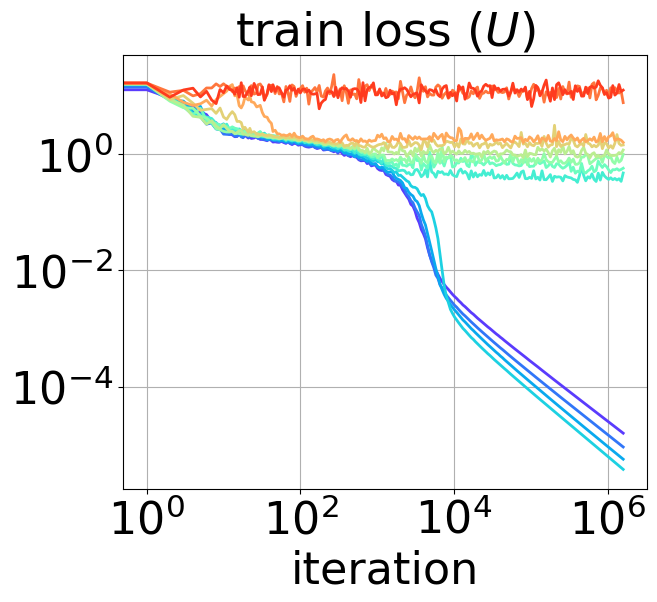

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
fig.tight_layout()

cmap = sns.color_palette('rainbow', len(lrs_id))

for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['train_loss'])]
    ax.plot(iters, trace_op[lr_id]['train_loss'], color=cmap[i],
            label=f'{lrs_op[lr_id]:.1e}', linewidth=2)
    
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_yticks(10. ** np.array([-4, -2, 0]))
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
ax.set_title('train loss ($U$)', fontsize=34)
ax.set_xlabel('iteration')
fig.savefig(f'{plot_folder}op_loss_iter_conv.png', dpi=200, bbox_inches='tight')

#### OP entropy iter

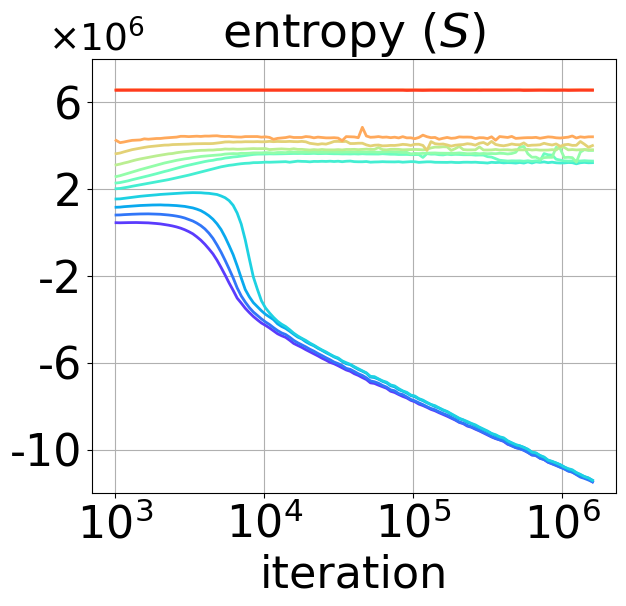

In [6]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
fig.tight_layout()

cmap = sns.color_palette('rainbow', len(lrs_id))

for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['train_loss'])]
    ents = [x.squeeze()[k_id] for x in trace_op[lr_id]['traj_ents']]
    ax.plot(iters, ents, color=cmap[i], label=f'{lrs_op[lr_id]:.1e}', linewidth=2)
ax.grid(True)
ax.set_xscale('log')
ax.set_yticks([-10e6, -6e6, -2e6, 2e6, 6e6])
ax.set_xticks(10 ** np.array([3, 4, 5, 6]))
ax.set_ylim(-12e6, 8e6)

scale      = 1e6             
ndecimals  = 1                

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{int(y/scale)}')
)
ax.annotate(r'$\times 10^6$',
                 xy=(0.1, 1.), xycoords='axes fraction',
                 ha='right', va='bottom', fontsize=27)
ax.set_title('entropy ($S$)', fontsize=34)
ax.set_xlabel('iteration')
fig.savefig(f'{plot_folder}op_entropy_iter_conv.png', dpi=200, bbox_inches='tight')

### UP loss and ent

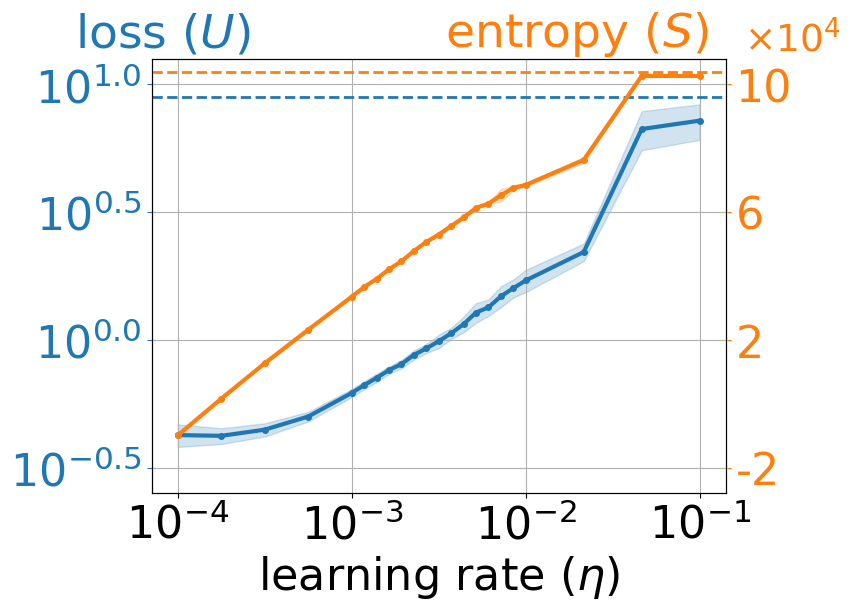

In [7]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.tight_layout()

loss_color = matplotlib.cm.tab10(0)
ent_color = matplotlib.cm.tab10(1)

up_uniform_ent = 103784.74
up_uniform_loss = 8.923859665039062

def get_stats(trace, lrs):
    final_loss = [np.array(trace[i]['train_loss'][-window:]) for i in range(len(lrs))]
    final_ent = [[np.array([x.squeeze()[k] for x in trace[i]['traj_ents']])[-window:] for i in range(len(lrs)) ] for k in range(len(ks))]
    final_ent_stoch = [[np.array([x.squeeze()[k] for x in trace[i]['stoch_ents']])[-window:] for i in range(len(lrs)) ] for k in range(len(ks))]
    return final_loss, final_ent, final_ent_stoch

fl_up, ent_up, _ = get_stats(trace_up, lrs_up)

fl_mean = []
fl_std = []
ents_mean = []
ents_std = []
for i, lr in enumerate(lrs_up):
    fl_mean.append(np.array(fl_up[i]).mean())
    fl_std.append(np.array(fl_up[i]).std())
    ents_mean.append(np.array(ent_up[k_id][i]).mean())
    ents_std.append(np.array(ent_up[k_id][i]).std())
fl_mean = np.array(fl_mean)
fl_std = np.array(fl_std)
ents_mean = np.array(ents_mean)
ents_std = np.array(ents_std)
        
ax_twin = ax.twinx()        

ax.plot(lrs_up, fl_mean, lw=3., marker='o', ms=4, color=loss_color)
ax.fill_between(lrs_up, fl_mean-fl_std, fl_mean+fl_std, alpha=.2, color=loss_color) 
ax.axhline(up_uniform_loss, color=loss_color, linestyle='--', lw=2, label='loss')

ax_twin.plot(lrs_up, ents_mean, lw=3., marker='o', ms=4, color=ent_color)
ax_twin.fill_between(lrs_up, ents_mean-ents_std, ents_mean+ents_std, alpha=.2, color=ent_color) 
ax_twin.axhline(up_uniform_ent, color=ent_color, linestyle='--', lw=2, label='entropy')

h_loss, label_loss = ax.get_legend_handles_labels()
h_ent, label_ent = ax_twin.get_legend_handles_labels()

ax.grid(which='major')

ax.tick_params(axis='y', colors=loss_color)
ax.yaxis.label.set_color(loss_color)
ax_twin.tick_params(axis='y', colors=ent_color)
ax_twin.yaxis.label.set_color(ent_color)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('learning rate ($\eta$)')
ax.set_title('loss ($U$)', color=loss_color, x=0.02, y=1.01, fontsize=34)
ax_twin.set_title('entropy ($S$)', color=ent_color, x=0.74, y=1.01, fontsize=34)

scale      = 1e4                
ndecimals  = 0                  
nticks     = 4                 

ax_twin.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{y/scale:.{ndecimals}f}')
)

loss_ticks = 10 ** np.array([-0.5, 0.0, 0.5, 1.0])
ent_ticks = [-2e4, 2e4, 6e4, 10e4]
ax.set_yticks(loss_ticks)
ax.set_yticks([], [], minor=True)
ax_twin.set_yticks(ent_ticks)

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$'))# if y != 1.0 else rf'$10^0$'))
)

ax.set_ylim(10. ** -0.6, 10 ** 1.1) 
ax_twin.set_ylim(ent_ticks[0] - (ent_ticks[1] - ent_ticks[0]) / 5, ent_ticks[-1] + (ent_ticks[1] - ent_ticks[0]) / 5)

ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])

ax_twin.annotate('$\\times 10^4$',
                 xy=(1.2, 1.), xycoords='axes fraction',
                 ha='right', va='bottom', fontsize=27, color=ent_color)
plt.savefig(f'{plot_folder}/up_loss_ent_lr_conv.png', dpi=200, bbox_inches='tight')

In [8]:
def calculate_temps(lrs, energy, entropy, eps=0.0):
    mn_t = np.zeros(len(lrs))
    mx_t = np.zeros(len(lrs))
    for i in range(len(lrs)):
        min_t = 0
        max_t = 2e18
        for j in range(len(lrs)):
            if i == j:
                continue
            v = (energy[i] - energy[j] - eps) / (entropy[i] - entropy[j])
            if i < j:
                max_t = min(max_t, v)
            else:
                min_t = max(min_t, v)

        if min_t == 0:
            min_t = max_t 
        elif max_t == 2e18:
            max_t = min_t
        mn_t[i] = min_t
        mx_t[i] = max_t
    return np.array(mn_t), np.array(mx_t)

In [9]:
fl_up, ent_up, _ = get_stats(trace_up, lrs_up)

fl_mean = []
ents_mean = []
for i, lr in enumerate(lrs_up):
    fl_mean.append(np.array(fl_up[i]).mean())
    ents_mean.append(np.array(ent_up[k_id][i]).mean())
fl_mean = np.array(fl_mean)
ents_mean = np.array(ents_mean)

r1, r2 = 1, len(lrs_up) - 3
U = fl_mean[r1:r2]
S = ents_mean[r1:r2]
log_lrs = np.log(lrs_up[r1:r2])
F = np.maximum(0.3 - np.abs(log_lrs[None, :] - log_lrs[:, None]), 0)
F /= F.sum(axis=1, keepdims=True)
F[0] = np.zeros(F.shape[0])
F[0, 0] = 1.
F[-1] = np.zeros(F.shape[0])
F[-1, -1] = 1.

mn, mx = calculate_temps(lrs_up[r1:r2], F @ U, F @ S, eps=1e-2)
tmp_mean = np.exp((np.log(mn) + np.log(mx)) / 2)

### UP Temperature

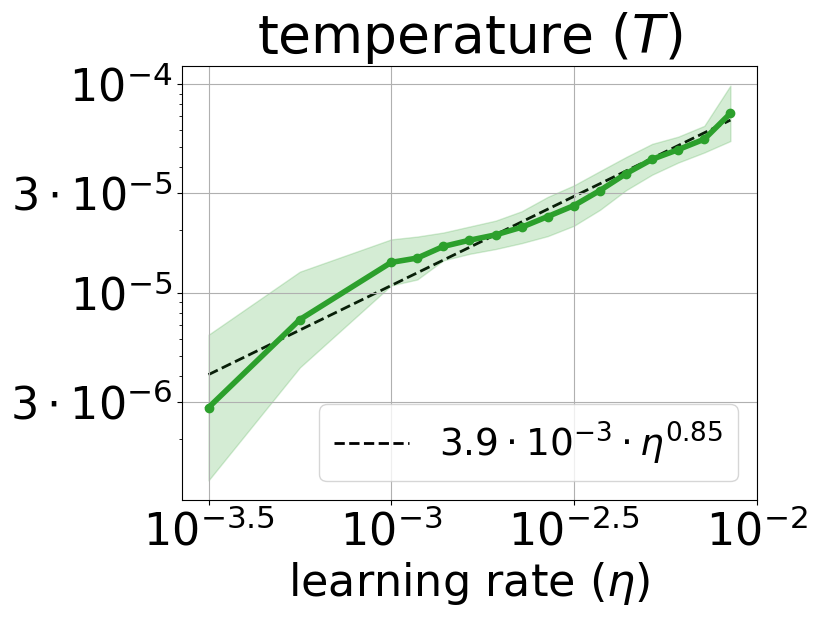

In [10]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.tight_layout()

temp_color = matplotlib.cm.tab10(2)

ax.plot(lrs_up[r1 + 1:r2 - 1], tmp_mean[1:-1], lw=4., color=temp_color, marker='o')
ax.fill_between(lrs_up[r1 + 1:r2 - 1], mn[1:-1], mx[1:-1], alpha=.2, color=temp_color)   #  instead of bars
coef_k, coef_b = linear_fit(np.log(lrs_up[r1 + 1:r2 - 1]), np.log(tmp_mean[1:-1]))
coef_b = np.exp(coef_b)
plt.plot(lrs_up[r1 + 1:r2 - 1], coef_b * lrs_up[r1 + 1:r2 - 1] ** coef_k,
         color='black', lw=2, linestyle='--', zorder=0,
         label='$' + f'{coef_b:.1e}'.replace('e-03', '\cdot 10^{-3}') + '\cdot \eta^{' + f'{coef_k:.2f}' + '} $')
ax.legend(fontsize=27, loc='lower right')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('learning rate ($\eta$)')
ax.set_title('temperature ($T$)')
ax.set_xticks([], [], minor=True)
ax.set_xticks([10 ** -3.5, 1e-3, 10. ** -2.5, 1e-2], ['$10^{-3.5}$', '$10^{-3}$', '$10^{-2.5}$', '$10^{-2}$'])
ax.set_yticks([3e-6, 1e-5, 3e-5, 1e-4],
                ['$3 \cdot 10^{-6}$','$10^{-5}$','$3 \cdot 10^{-5}$','$10^{-4}$'])
ax.grid()
plt.savefig(f'{plot_folder}/up_temp_conv.png', dpi=200, bbox_inches='tight')

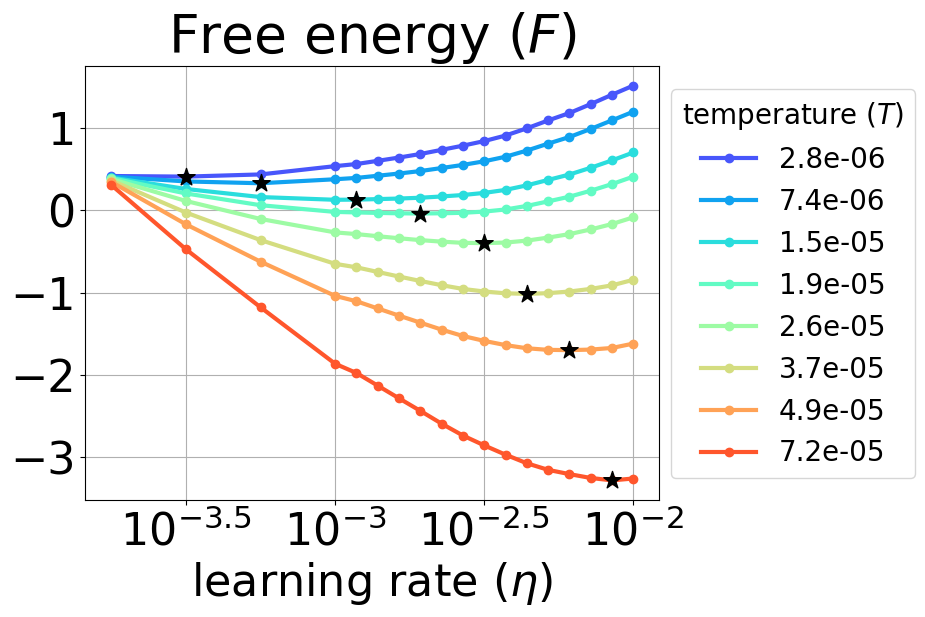

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.tight_layout()
ids_range = [r1 + 1, r1 + 2, r1 + 4, r1 + 7, r1 + 10, r1 + 12, r1 + 14, r1 + 16]
colors = sns.color_palette('rainbow', len(ids_range))
for i, ind in enumerate(ids_range):
    plt.plot(lrs_up[r1:r2], (F @ U) - tmp_mean[ind - r1] * (F @ S), color=colors[i],
             linewidth=3, marker='o', label=f'{tmp_mean[ind - r1]:.1e}')
    plt.scatter(lrs_up[ind], (F @ U)[ind - r1] - tmp_mean[ind - r1] * (F @ S)[ind - r1],
                color='black', marker='*', s=170, zorder=10)

legend = ax.legend(title='temperature ($T$)', fontsize=20, loc=(1.02, 0.05))
plt.setp(legend.get_title(),fontsize=20)
ax.set_xscale('log')
ax.set_xticks([], [], minor=True)
ax.set_xticks([10 ** -3.5, 1e-3, 10. ** -2.5, 1e-2], ['$10^{-3.5}$', '$10^{-3}$', '$10^{-2.5}$', '$10^{-2}$'])
ax.set_yticks(np.arange(-3, 1.1, 1))
ax.set_title('Free energy ($F$)')
ax.set_xlabel('learning rate ($\eta$)')
ax.grid()
plt.savefig(f'{plot_folder}/up_free_energy_conv.png', dpi=200, bbox_inches='tight')

### OP loss and ent

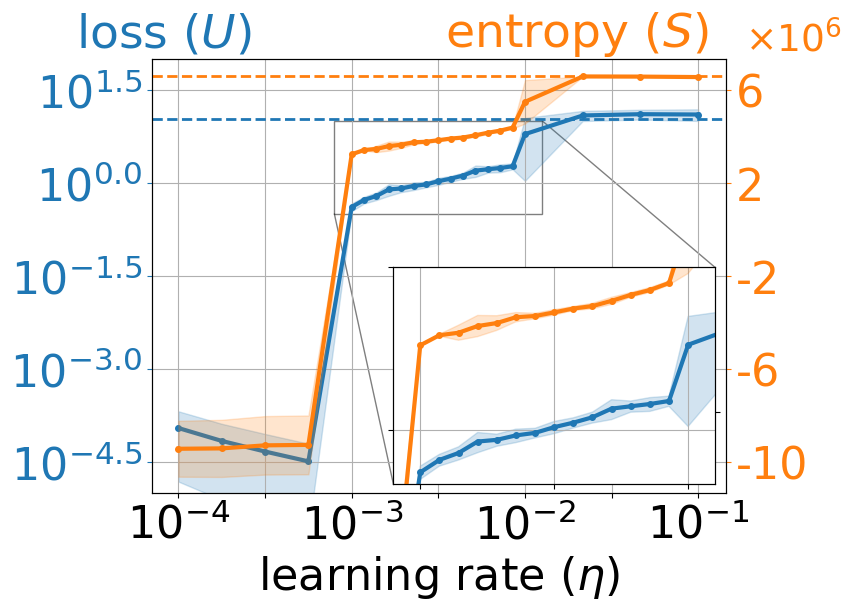

In [12]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.tight_layout()

loss_color = matplotlib.cm.tab10(0)
ent_color = matplotlib.cm.tab10(1)

op_uniform_ent = 6599658.0
op_uniform_loss = 10.557629901171873


def get_stats(trace, lrs):
    final_loss = [np.array(trace[i]['train_loss'][-window:]) for i in range(len(lrs))]
    final_ent = [[np.array([x.squeeze()[k] for x in trace[i]['traj_ents']])[-window:] for i in range(len(lrs)) ] for k in range(len(ks))]
    final_ent_stoch = [[np.array([x.squeeze()[k] for x in trace[i]['stoch_ents']])[-window:] for i in range(len(lrs)) ] for k in range(len(ks))]
    return final_loss, final_ent, final_ent_stoch

fl_op, ent_op, _ = get_stats(trace_op, lrs_op)

fl_mean = []
fl_std = []
ents_mean = []
ents_std = []
for i, lr in enumerate(lrs_op):
    fl_mean.append(np.array(fl_op[i]).mean())
    fl_std.append(np.array(fl_op[i]).std())
    ents_mean.append(np.array(ent_op[k_id][i]).mean())
    ents_std.append(np.array(ent_op[k_id][i]).std())
fl_mean = np.array(fl_mean)
fl_std = np.array(fl_std)
ents_mean = np.array(ents_mean)
ents_std = np.array(ents_std)
        
ax_twin = ax.twinx()

ax.plot(lrs_op, fl_mean, lw=3., marker='o', ms=4, color=loss_color)
ax.fill_between(lrs_op, fl_mean-fl_std, fl_mean+fl_std, alpha=.2, color=loss_color)   # instead of bars
ax.axhline(op_uniform_loss, color=loss_color, linestyle='--', lw=2, label='loss')

ax_twin.plot(lrs_op, ents_mean, lw=3., marker='o', ms=4, color=ent_color)
ax_twin.fill_between(lrs_op, ents_mean-ents_std, ents_mean+ents_std, alpha=.2, color=ent_color) 
ax_twin.axhline(op_uniform_ent, color=ent_color, linestyle='--', lw=2, label='loss')

ax_in = ax.inset_axes([0.42, 0.02, 0.56, 0.5], xlim=(10 ** -3.1, 10 ** -1.9), ylim=(10 ** -0.5, 10 ** 1))
ax.indicate_inset_zoom(ax_in, edgecolor="black", zorder=-1)
ax_in.plot(lrs_op, fl_mean, lw=3., marker='o', ms=4, color=loss_color)
ax_in.fill_between(lrs_op, fl_mean-fl_std, fl_mean+fl_std, alpha=.2, color=loss_color) 
ax_in.set_xscale('log')
ax_in.set_yscale('log')
ax_in.set_xticks([], [], minor=True)
ax_in.set_xticks([1e-3, 10 ** -2.5, 1e-2], ['', '', ''])
ax_in.set_yticks([], [], minor=True)
ax_in.set_yticks([1, 10 ** 1.5], [])
ax_in.grid()

ax_in_twin = ax_in.twinx()
ax_in_twin.plot(lrs_op, ents_mean, lw=3., marker='o', ms=4, color=ent_color)
ax_in_twin.fill_between(lrs_op, ents_mean-ents_std, ents_mean+ents_std, alpha=.2, color=ent_color) 
ax_in_twin.set_yticks([], [], minor=True)
ax_in_twin.set_yticks([2e6, 6e6], [])
ax_in_twin.set_ylim((2 - 4/3) * 1e6, (6 - 4/3) * 1e6)


ax.grid(which='major')

ax.tick_params(axis='y', colors=loss_color)
ax.yaxis.label.set_color(loss_color)
ax_twin.tick_params(axis='y', colors=ent_color)
ax_twin.yaxis.label.set_color(ent_color)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('learning rate ($\eta$)')
ax.set_title('loss ($U$)', color=loss_color, x=0.02, y=1.01, fontsize=34)
ax_twin.set_title('entropy ($S$)', color=ent_color, x=0.74, y=1.01, fontsize=34)

scale      = 1e6                
ndecimals  = 0                
nticks     = 4                 

ax_twin.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{y/scale:.{ndecimals}f}')
)
ax_twin.annotate('$\\times 10^6$',
                 xy=(1.2, 1.), xycoords='axes fraction',
                 ha='right', va='bottom', fontsize=27, color=ent_color)

loss_ticks = 10. ** np.array([-4.5, -3, -1.5, 0, 1.5])
ent_ticks = [-10e6, -6e6, -2e6, 2e6, 6e6]
ax.set_yticks(loss_ticks)
ax_twin.set_yticks(ent_ticks)

ax.yaxis.set_major_formatter(
   FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$'))# if y != 1.0 else rf'$10^0$'))
)

ax.set_ylim(10. ** -5, 10 ** 2) 
ax_twin.set_ylim(ent_ticks[0] - (ent_ticks[1] - ent_ticks[0]) / 3, ent_ticks[-1] + (ent_ticks[1] - ent_ticks[0]) / 3)

ax.set_xticks(
    [1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1],
    ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$']
)

plt.savefig(f'{plot_folder}/op_loss_ent_lr_conv.png', dpi=200, bbox_inches='tight')

In [13]:
fl_op, ent_op, _ = get_stats(trace_op, lrs_op)

fl_mean = []
ents_mean = []
for i, lr in enumerate(lrs_op):
    fl_mean.append(np.array(fl_op[i]).mean())
    ents_mean.append(np.array(ent_op[k_id][i]).mean())
fl_mean = np.array(fl_mean)
ents_mean = np.array(ents_mean)

r1, r2 = 4, len(lrs_op) - 7
U = fl_mean[r1:r2]
S = ents_mean[r1:r2]
log_lrs = np.log(lrs_op[r1:r2])
F = np.maximum(0.3 - np.abs(log_lrs[None, :] - log_lrs[:, None]), 0)
F /= F.sum(axis=1, keepdims=True)
F[0] = np.zeros(F.shape[0])
F[0, 0] = 1.
F[-1] = np.zeros(F.shape[0])
F[-1, -1] = 1.

mn, mx = calculate_temps(lrs_op[r1:r2], F @ U, F @ S, eps=4e-2)
tmp_mean = np.exp((np.log(mn) + np.log(mx)) / 2)

### OP Temperature

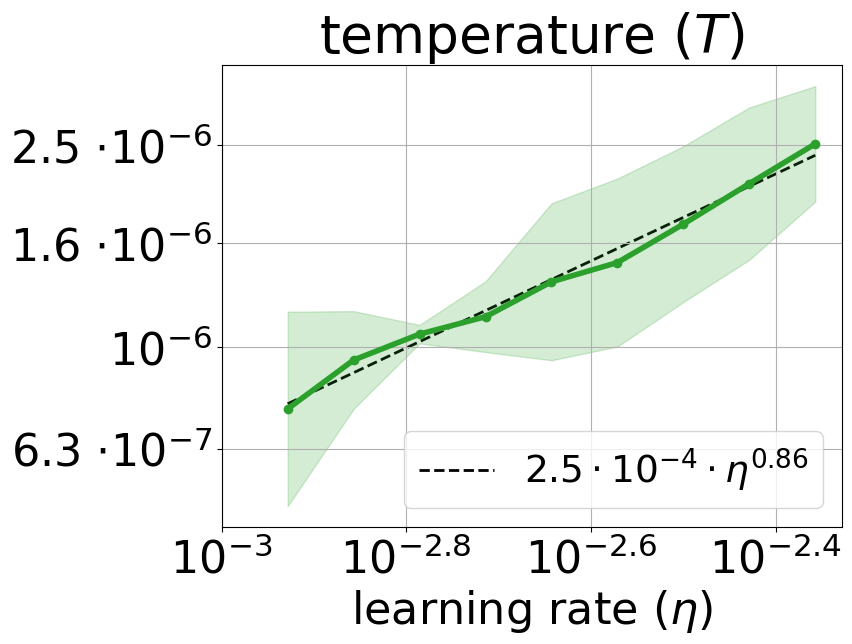

In [14]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

temp_color = matplotlib.cm.tab10(2)

ax.plot(lrs_up[r1 + 1:r2 - 1], tmp_mean[1:-1], lw=4., color=temp_color, marker='o')
ax.fill_between(lrs_up[r1 + 1:r2 - 1], mn[1:-1], mx[1:-1], alpha=.2, color=temp_color)  
coef_k, coef_b = linear_fit(np.log(lrs_up[r1 + 1:r2 - 1]), np.log(tmp_mean[1:-1]))
coef_b = np.exp(coef_b)
plt.plot(lrs_up[r1 + 1:r2 - 1], coef_b * lrs_up[r1 + 1:r2 - 1] ** coef_k,
         color='black', lw=2, linestyle='--', zorder=0,
         label='$' + f'{coef_b:.1e}'.replace('e-04', '\cdot 10^{-4}') + '\cdot \eta^{' + f'{coef_k:.2f}' + '} $')
ax.legend(fontsize=27, loc='lower right')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('learning rate ($\eta$)')
ax.set_title('temperature ($T$)')
ax.set_xticks([], [], minor=True)
ax.set_xticks(
    [1e-3, 10 ** -2.8, 10. ** -2.6, 10 ** -2.4],
    ['$10^{-3}$', '$10^{-2.8}$', '$10^{-2.6}$', '$10^{-2.4}$']
)
ax.set_yticks([], [], minor=True)
ax.set_yticks(
    [6.3e-7, 1e-6, 1.6e-6, 2.5e-6],
    ['6.3 $\cdot 10^{-7}$', '$10^{-6}$', '1.6 $\cdot 10^{-6}$', '2.5 $\cdot 10^{-6}$']
)
ax.grid()
plt.savefig(f'{plot_folder}/op_temp_conv.png', dpi=200, bbox_inches='tight')

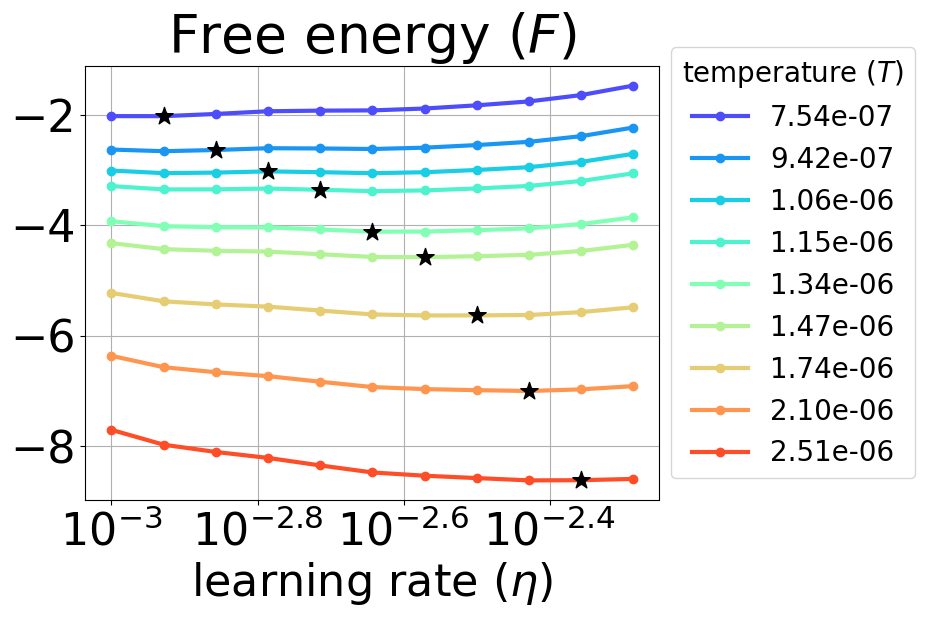

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.tight_layout()
ids_range = range(r1 + 1, r2 - 1)
colors = sns.color_palette('rainbow', len(ids_range))
for i, ind in enumerate(ids_range):
    plt.plot(lrs_op[r1:r2], (F @ U) - tmp_mean[ind - r1] * (F @ S), color=colors[i],
             linewidth=3, marker='o', label=f'{tmp_mean[ind - r1]:.2e}')
    plt.scatter(lrs_op[ind], (F @ U)[ind - r1] - tmp_mean[ind - r1] * (F @ S)[ind - r1],
                color='black', marker='*', s=170, zorder=10)

legend = ax.legend(title='temperature ($T$)', fontsize=20, loc=(1.02, 0.05))
plt.setp(legend.get_title(),fontsize=20)
ax.set_xscale('log')
ax.set_xticks([], [], minor=True)
ax.set_xticks(
    [1e-3, 10 ** -2.8, 10. ** -2.6, 10 ** -2.4],
    ['$10^{-3}$', '$10^{-2.8}$', '$10^{-2.6}$', '$10^{-2.4}$']
)
ax.set_yticks(np.arange(-8, -1.9, 2))
ax.set_title('Free energy ($F$)')
ax.set_xlabel('learning rate ($\eta$)')
ax.grid()
plt.savefig(f'{plot_folder}/op_free_energy_conv.png', dpi=200, bbox_inches='tight')

### OP Temperature Decay

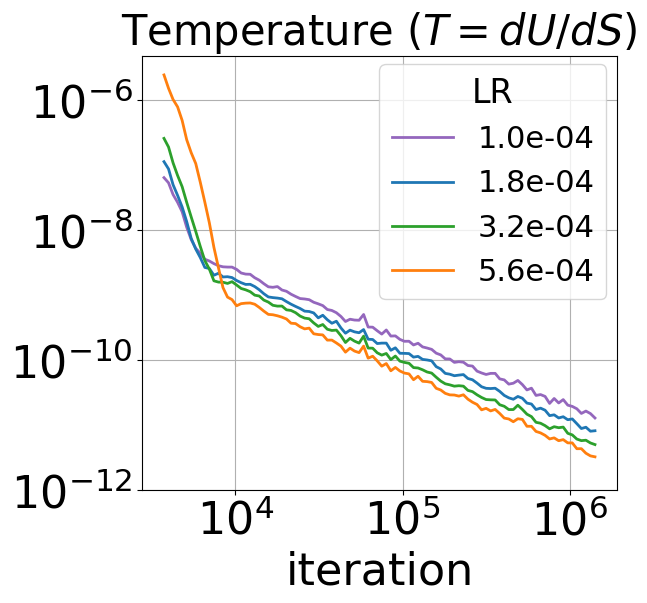

In [16]:
num_vals = 100

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
fig.tight_layout()
dt = 2
colors = [plt.cm.tab10(4), plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]

for i in range(4):
    U = np.array(trace_op[i]['train_loss'][-num_vals:])
    S = torch.stack(trace_op[i]['traj_ents'][-num_vals:])[:, k_id].numpy().astype(np.float64)
    T = (U[2 * dt:] - U[:-2 * dt]) / (S[2 * dt:] - S[:-2 * dt])
    ax.plot(iters[-num_vals+dt:-dt], T, lw=2, label=f'{lrs_op[i]:.1e}', color=colors[i])

legend = ax.legend(title='LR', fontsize=22, loc=(0.5, 0.44))
plt.setp(legend.get_title(),fontsize=24)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')
ax.set_title('Temperature ($T=dU/dS$)', fontsize=30)
ax.set_xticks([], [], minor=True)
ax.set_yticks([1e-12, 1e-10, 1e-8, 1e-6])
ax.grid()
plt.savefig(f'{plot_folder}/op_temp1_conv.png', dpi=200, bbox_inches='tight')